In [1]:
%cd ".."

/home/id1896/python/2A/projet-statistique-2022


In [2]:
import pandas as pd
import itertools
import time
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import seaborn as sns
import shutil

# BATS reference

In [3]:
df_evaluation_bats = pd.read_csv("data/tuning/evaluation_bats.csv",sep=";")
df_evaluation_bats.head()

,models_filename,type_model,windows,dim_emb,ref_err_dis_cos,ref_rmse_dis_cos,ref_err_moy_freq,ref_rmse_freq
0,cbow_4_20.kv,cbow,4,20,-0.656288,0.700103,0.148443,0.400323
1,cbow_10_300.kv,cbow,10,300,-0.779008,0.796776,0.143089,0.406280
2,cbow_8_140.kv,cbow,8,140,-0.763201,0.782621,0.147788,0.405896
3,skipgram_10_280.kv,skipgram,10,280,-0.748005,0.767755,0.318122,0.515386
4,cbow_7_300.kv,cbow,7,300,-0.775628,0.793835,0.142745,0.403255


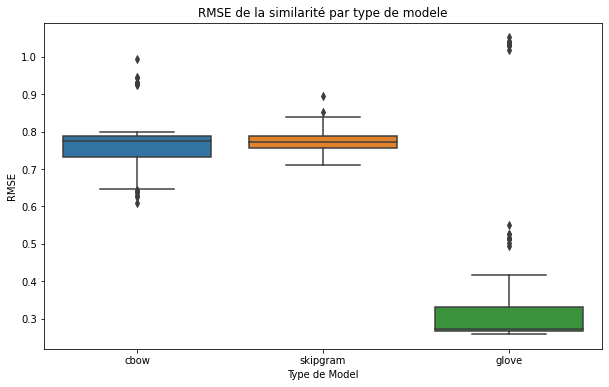

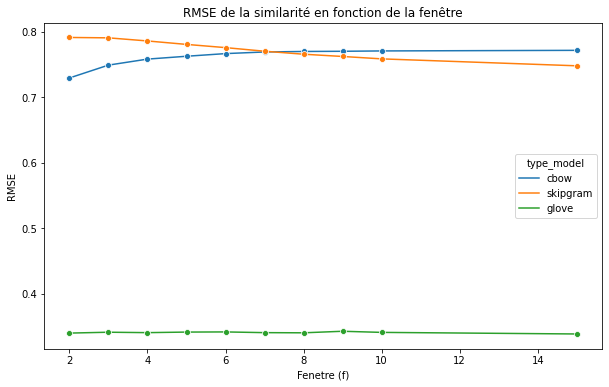

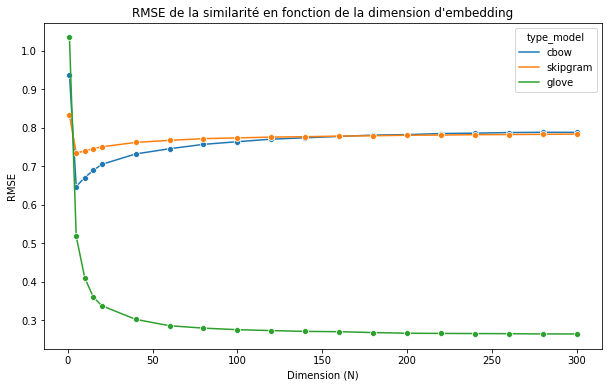

In [19]:
# Plot RMSE DIS COS
plt.figure(figsize = (10,6))

sns.boxplot(x="type_model",y="ref_rmse_dis_cos",data=df_evaluation_bats)
plt.ylabel('RMSE')
plt.xlabel("Type de Model")
plt.title("RMSE de la similarité par type de modele")
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize = (10,6))
sns.lineplot(x="windows",y="ref_rmse_dis_cos",hue="type_model",data=df_evaluation_bats,ci = None,markers=True,marker="o")
plt.ylabel('RMSE')
plt.xlabel("Fenetre (f)")
plt.title("RMSE de la similarité en fonction de la fenêtre")
plt.show()

plt.figure(figsize = (10,6))
sns.lineplot(x="dim_emb",y="ref_rmse_dis_cos",hue="type_model",data=df_evaluation_bats,ci = None,markers=True,marker="o")
plt.ylabel('RMSE')
plt.xlabel("Dimension (N)")
plt.title("RMSE de la similarité en fonction de la dimension d'embedding")
plt.show()

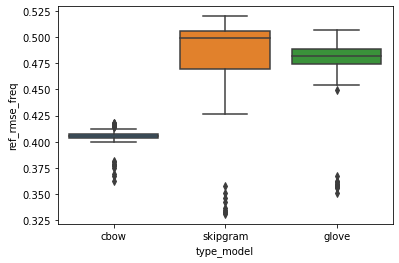

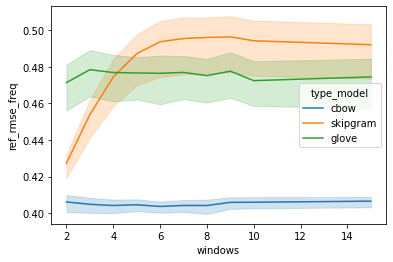

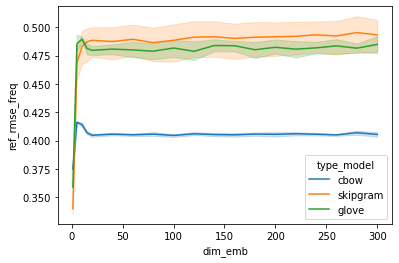

In [5]:
# Plot RMSE FREQ
sns.boxplot(x="type_model",y="ref_rmse_freq",data=df_evaluation_bats)
plt.show()
sns.lineplot(x="windows",y="ref_rmse_freq",hue="type_model",data=df_evaluation_bats)
plt.show()
sns.lineplot(x="dim_emb",y="ref_rmse_freq",hue="type_model",data=df_evaluation_bats)
plt.show()

In [13]:
# Best model
best_models = df_evaluation_bats.loc[df_evaluation_bats.groupby("type_model")["ref_rmse_dis_cos"].idxmin()]
print(best_models)
best_glove_filename = best_models.loc[best_models["type_model"] == "glove"]["models_filename"].values[0]
best_cbow_filename = best_models["models_filename"].loc[best_models["type_model"] == "cbow"].values[0]
best_skipgram_filename = best_models["models_filename"].loc[best_models["type_model"] == "skipgram"].values[0]

# Special case for glove (take smallest dim)
best_models2 = df_evaluation_bats.loc[df_evaluation_bats[df_evaluation_bats["dim_emb"]<100].groupby("type_model")["ref_rmse_dis_cos"].idxmin()]
best_glove_filename2 = best_models2.loc[best_models2["type_model"] == "glove"]["models_filename"].values[0]
best_models2

     models_filename type_model  windows  dim_emb  ref_err_dis_cos  \
192      cbow_2_5.kv       cbow        2        5        -0.423823   
125  glove_10_300.kv      glove       10      300         0.196886   
118  skipgram_2_5.kv   skipgram        2        5        -0.673534   

     ref_rmse_dis_cos  ref_err_moy_freq  ref_rmse_freq  
192          0.608565          0.181264       0.417234  
125          0.259422          0.277005       0.472056  
118          0.710756          0.211039       0.426897  


,models_filename,type_model,windows,dim_emb,ref_err_dis_cos,ref_rmse_dis_cos,ref_err_moy_freq,ref_rmse_freq
192,cbow_2_5.kv,cbow,2,5,-0.423823,0.608565,0.181264,0.417234
190,glove_10_80.kv,glove,10,80,0.192936,0.269446,0.273180,0.454548
118,skipgram_2_5.kv,skipgram,2,5,-0.673534,0.710756,0.211039,0.426897


In [14]:
#Load model as Keyedvectors
best_glove = KeyedVectors.load_word2vec_format(f"data/training_models/{best_glove_filename}")
best_cbow = KeyedVectors.load_word2vec_format(f"data/training_models/{best_cbow_filename}")
best_skipgram = KeyedVectors.load_word2vec_format(f"data/training_models/{best_skipgram_filename}")

In [15]:
#Load model as Keyedvectors
best_glove2 = KeyedVectors.load_word2vec_format(f"data/training_models/{best_glove_filename2}")

In [10]:
lemm_test = "dechet"

print(f"Glove most similaire to {lemm_test}: \n{best_glove.most_similar(lemm_test)}\n")
print(f"Cbow most similaire to {lemm_test}: \n{best_cbow.most_similar(lemm_test)}\n")
print(f"skipgram most similaire to {lemm_test}: \n{best_skipgram.most_similar(lemm_test)}")

Glove most similaire to dechet: 
[('produire', 0.21669083833694458), ('mercure', 0.19848056137561798), ('votee', 0.1929606944322586), ('banquette', 0.19027914106845856), ('embouteillage', 0.1862686276435852), ('redonner', 0.18548282980918884), ('plant', 0.17312553524971008), ('tva', 0.1728728860616684), ('extremement', 0.17108896374702454), ('lourd', 0.16794127225875854)]

Cbow most similaire to dechet: 
[('region', 0.9995194673538208), ('main', 0.9994471073150635), ('localement', 0.9992453455924988), ('poubelle', 0.9990654587745667), ('idee', 0.9988109469413757), ('quartier', 0.9987856149673462), ('abattoir', 0.9987754821777344), ('individu', 0.9987151622772217), ('rien', 0.9986613988876343), ('engager', 0.9985846281051636)]

skipgram most similaire to dechet: 
[('antibiotique', 0.9984840750694275), ('greenwashing', 0.998382568359375), ('shampooing', 0.99803626537323), ('co_deux', 0.9966737031936646), ('fermement', 0.9961792230606079), ('verifier', 0.9960604906082153), ('placement', 0

In [10]:
# Select best model
shutil.copy2(src=f"../data/training_models/{best_glove_filename}",dst="data/tuning/glove.kv")
shutil.copy2(src=f"../data/training_models/{best_cbow_filename}",dst="data/tuning/cbow.kv")
shutil.copy2(src=f"../data/training_models/{best_skipgram_filename}",dst="data/tuning/skipgram.kv")

'../data/tuning/skipgram.kv'

In [16]:
# Select best model
shutil.copy2(src=f"data/training_models/{best_glove_filename2}",dst="data/tuning/glove2.kv")

'data/tuning/glove2.kv'

# Tag similarity

In [3]:

df_evaluation_tags = pd.read_csv("data/tuning/evaluation_tags.csv",sep=";")
df_evaluation_tags.head()

,models_filename,type_model,windows,dim_emb,tag_mse
0,cbow_4_20.kv,cbow,4,20,0.069097
1,cbow_10_300.kv,cbow,10,300,0.144852
2,cbow_8_140.kv,cbow,8,140,0.130047
3,skipgram_10_280.kv,skipgram,10,280,0.157504
4,cbow_7_300.kv,cbow,7,300,0.141684


In [4]:
df_tag_similarity = pd.read_csv("data/tuning/tag_similiraty.csv",sep=";",index_col=0)
df_tag_similarity.head()

,maladie,bateau,kilomètre,lobbying,coherence,paquebot,efforcer,utilise,dent,bio,...,prelever,abrite,crique,forme,vegetation,arborer,couture,universitaire,sdf,precaution
maladie,1.000000,0.793442,0.821735,0.773087,0.751749,0.766154,0.000000,0.785872,0.709372,0.799103,...,0.631169,0.405751,0.246932,0.854790,0.721913,0.811503,0.567561,0.405751,0.321012,0.699400
bateau,0.793442,1.000000,0.978896,0.724264,0.695846,0.898622,0.028287,0.854019,0.564587,0.804073,...,0.750630,0.381089,0.360536,0.813316,0.630572,0.513893,0.559548,0.386863,0.268820,0.773181
kilomètre,0.821735,0.978896,1.000000,0.729316,0.699683,0.864785,0.014942,0.851120,0.622170,0.835807,...,0.689306,0.457504,0.347478,0.852828,0.672032,0.524605,0.576850,0.427004,0.287338,0.772005
lobbying,0.773087,0.724264,0.729316,1.000000,0.875828,0.680485,0.129641,0.865158,0.691493,0.798446,...,0.740959,0.449868,0.463817,0.871533,0.618666,0.688033,0.604306,0.449868,0.391345,0.745434
coherence,0.751749,0.695846,0.699683,0.875828,1.000000,0.602595,0.000000,0.771800,0.603392,0.763177,...,0.715829,0.463184,0.369012,0.825992,0.647291,0.589506,0.517769,0.463184,0.230633,0.807947


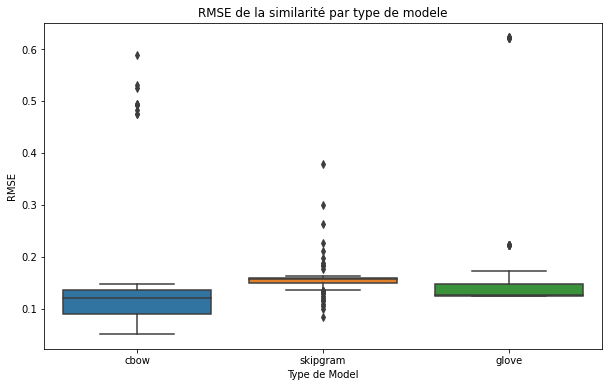

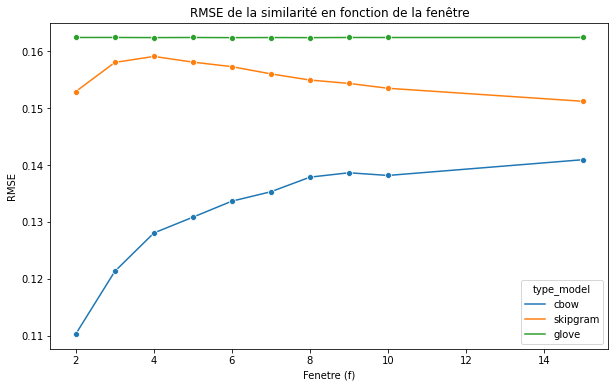

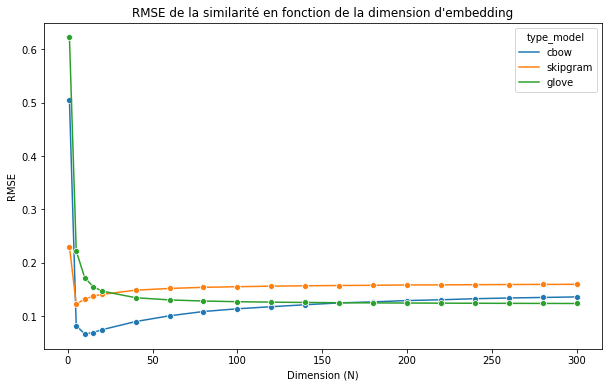

In [5]:
# Plot RMSE DIS COS
plt.figure(figsize = (10,6))

sns.boxplot(x="type_model",y="tag_mse",data=df_evaluation_tags)
plt.ylabel('RMSE')
plt.xlabel("Type de Model")
plt.title("RMSE de la similarité par type de modele")
plt.ylabel('RMSE')
plt.show()

plt.figure(figsize = (10,6))
sns.lineplot(x="windows",y="tag_mse",hue="type_model",data=df_evaluation_tags,ci = None,markers=True,marker="o")
plt.ylabel('RMSE')
plt.xlabel("Fenetre (f)")
plt.title("RMSE de la similarité en fonction de la fenêtre")
plt.show()

plt.figure(figsize = (10,6))
sns.lineplot(x="dim_emb",y="tag_mse",hue="type_model",data=df_evaluation_tags,ci = None,markers=True,marker="o")
plt.ylabel('RMSE')
plt.xlabel("Dimension (N)")
plt.title("RMSE de la similarité en fonction de la dimension d'embedding")
plt.show()

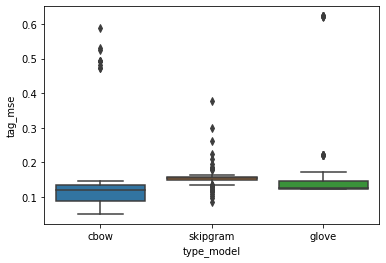

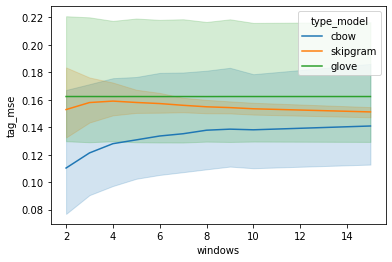

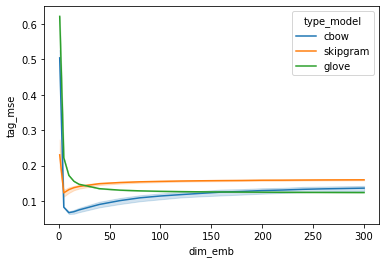

In [6]:
sns.boxplot(x="type_model",y="tag_mse",data=df_evaluation_tags)
plt.show()
sns.lineplot(x="windows",y="tag_mse",hue="type_model",data=df_evaluation_tags)
plt.show()
sns.lineplot(x="dim_emb",y="tag_mse",hue="type_model",data=df_evaluation_tags)
plt.show()

In [14]:
# Best model
best_models = df_evaluation_tags.loc[df_evaluation_tags.groupby("type_model")["tag_mse"].idxmin()]
print(best_models)
best_glove_filename = best_models.loc[best_models["type_model"] == "glove"]["models_filename"].values[0]
best_cbow_filename = best_models["models_filename"].loc[best_models["type_model"] == "cbow"].values[0]
best_skipgram_filename = best_models["models_filename"].loc[best_models["type_model"] == "skipgram"].values[0]

#Load model as Keyedvectors
best_glove = KeyedVectors.load_word2vec_format(f"data/training_models/{best_glove_filename}")
best_cbow = KeyedVectors.load_word2vec_format(f"data/training_models/{best_cbow_filename}")
best_skipgram = KeyedVectors.load_word2vec_format(f"data/training_models/{best_skipgram_filename}")

     models_filename type_model  windows  dim_emb   tag_mse
268     cbow_2_15.kv       cbow        2       15  0.050996
114   glove_6_300.kv      glove        6      300  0.123722
118  skipgram_2_5.kv   skipgram        2        5  0.084496


In [15]:
lemm_test = "dechet"

print(f"Glove most similaire to {lemm_test}: \n{best_glove.most_similar(lemm_test)}\n")
print(f"Cbow most similaire to {lemm_test}: \n{best_cbow.most_similar(lemm_test)}\n")
print(f"skipgram most similaire to {lemm_test}: \n{best_skipgram.most_similar(lemm_test)}")

Glove most similaire to dechet: 
[('tri', 0.20408566296100616), ('toucheer', 0.1971530020236969), ('referendum', 0.19026713073253632), ('degagerer', 0.18905313313007355), ('autosuffisance', 0.18220750987529755), ('ascenseur', 0.18146735429763794), ('prevention', 0.17889033257961273), ('mmt', 0.17270037531852722), ('augmente', 0.17129585146903992), ('associer', 0.16643041372299194)]

Cbow most similaire to dechet: 
[('poubelle', 0.9994727969169617), ('environnemental', 0.9991818070411682), ('bon', 0.9991581439971924), ('terre', 0.9991459846496582), ('bureau', 0.9991077184677124), ('regle', 0.9990790486335754), ('nouveau', 0.9990236759185791), ('propre', 0.9989869594573975), ('developper', 0.9989635348320007), ('faire', 0.9989392161369324)]

skipgram most similaire to dechet: 
[('antibiotique', 0.9984840750694275), ('greenwashing', 0.998382568359375), ('shampooing', 0.99803626537323), ('co_deux', 0.9966737031936646), ('fermement', 0.9961792230606079), ('verifier', 0.9960604906082153), ('

In [17]:
df_tag_similarity.loc["climato",].sort_values(ascending=False)[:10]

climato          1.000000
laboratoire      0.795147
manipuler        0.730297
revendeur        0.730297
glitter          0.730297
negativ          0.730297
rasoir           0.730297
impossibilite    0.730297
repercute        0.730297
penalisee        0.730297
Name: climato, dtype: float64